In [1]:
import functools

import optax
import jax.numpy as jnp
import jax
import e3nn_jax as e3nn
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
import plotly.graph_objects as go

import sys
sys.path.append('../')

In [2]:
from symphony import loss
from symphony import models

In [3]:
target_positions = jnp.asarray([
    [[-1., 0., 0.], [0., -1., 0.], [0., 0., -1.], [0., 0., 0.]],
    [[1., 0., 0.], [0., 1., 0.], [0., 0., 0.], [0., 0., 0.]],
])
# target_positions = jnp.asarray([[[-1., 0., 0.], [0., -1., 0.]]])
# target_positions = jnp.asarray([[[1., 0., 0.], [0., 1., 0.], [0., 0., 0.], [0., 0., 0.]]])
target_position_mask = jnp.asarray([[True, True, True, False], [True, True, False, False]])
target_position_inverse_temperature = 10000.
# lmax = 3
lmax = 5
res_beta = 40
res_alpha = 39

In [4]:
log_true_angular_coeffs = jax.vmap(
    lambda pos: loss.target_position_to_log_angular_coeffs(
        pos, target_position_inverse_temperature=target_position_inverse_temperature, lmax=lmax,
    )
)(target_positions)

compute_grid_of_joint_distribution_fn = functools.partial(
        models.compute_grid_of_joint_distribution,
        res_beta=res_beta,
        res_alpha=res_alpha,
        quadrature="soft",
    )
true_angular_dist = jax.vmap(
    compute_grid_of_joint_distribution_fn,
)(jnp.ones((log_true_angular_coeffs.shape[0], 1)), log_true_angular_coeffs)
# true_angular_dist.grid_values = true_angular_dist.grid_values[:, :, 0, :, :]
# mean_true_angular_dist = e3nn.SphericalSignal(
#     grid_values=true_angular_dist.grid_values.mean(axis=1),
#     quadrature=true_angular_dist.quadrature
# )

num_graphs = target_positions.shape[0]
true_angular_dist.grid_values = true_angular_dist.grid_values[:, :, 0, :, :]
num_target_positions = jnp.sum(target_position_mask, axis=1).reshape(-1, 1, 1)
num_target_positions = jnp.maximum(num_target_positions, 1)
angular_dist_sum = jnp.sum(true_angular_dist.grid_values * target_position_mask.reshape(num_graphs, -1, 1, 1), axis=1)
angular_dist_mean = angular_dist_sum.reshape(-1, res_beta, res_alpha) / num_target_positions
mean_true_angular_dist = e3nn.SphericalSignal(
    grid_values=angular_dist_mean,
    quadrature=true_angular_dist.quadrature
)


# mean_true_angular_dist


In [5]:
num_radii = 1
radial_bins = jnp.linspace(1.0, 2.0, num_radii)
def target_position_to_joint_distribution(
    target_positions,  # (max_targets_per_graph, 3)
    radius_rbf_variance,
    target_position_inverse_temperature,
    lmax,
    res_beta,
    res_alpha,
    quadrature):
    true_radial_weights = jax.vmap(
        lambda pos: loss.target_position_to_radius_weights(
            pos, radius_rbf_variance, radial_bins
        )
    )(target_positions)
    log_true_angular_coeffs = jax.vmap(
        lambda pos: loss.target_position_to_log_angular_coeffs(
            pos, target_position_inverse_temperature, lmax
        )
    )(target_positions)

    assert true_radial_weights.shape[-1] == num_radii, true_radial_weights.shape
    assert log_true_angular_coeffs.shape[-1] == log_true_angular_coeffs.irreps.dim, log_true_angular_coeffs.shape
    assert true_radial_weights.shape[0] == log_true_angular_coeffs.shape[0]

    compute_joint_distribution_fn = functools.partial(
        models.compute_grid_of_joint_distribution,
        res_beta=res_beta,
        res_alpha=res_alpha,
        quadrature=quadrature,
    )
    joint_dist = jax.vmap(compute_joint_distribution_fn)(
        true_radial_weights, log_true_angular_coeffs
    )  # (max_targets_per_graph, num_radii, res_beta, res_alpha)
    return joint_dist

In [6]:
compute_joint_distribution_fn = functools.partial(
    target_position_to_joint_distribution,
    radius_rbf_variance=1e-3,
    target_position_inverse_temperature=target_position_inverse_temperature,
    lmax=lmax,
    res_beta=res_beta,
    res_alpha=res_alpha,
    quadrature="soft",
)
true_dist = jax.vmap(compute_joint_distribution_fn)(
    target_positions
)  # (num_graphs, max_targets_per_graph, num_radii, res_beta, res_alpha)
true_dist /= true_dist.integrate()
num_target_positions = jnp.sum(target_position_mask, axis=1).reshape(-1, 1, 1, 1)
dist_sum = jnp.sum(true_dist.grid_values * target_position_mask.reshape(num_graphs, -1, 1, 1, 1), axis=1)
dist_mean = dist_sum / num_target_positions
mean_true_dist = e3nn.SphericalSignal(
    grid_values=dist_mean.reshape(-1, res_beta, res_alpha),
    quadrature=true_dist.quadrature
)

ValueError: Einstein sum subscript 'r' does not contain the correct number of indices for operand 0.

In [7]:
def coeffs_to_dist(log_predicted_angular_coeffs):
    predicted_angular_dist = compute_grid_of_joint_distribution_fn(jnp.ones((1,)), log_predicted_angular_coeffs)
    predicted_angular_dist = predicted_angular_dist[:, 0, :, :]
    return predicted_angular_dist


def coeffs_to_logits(log_predicted_angular_coeffs):
    predicted_angular_dist = coeffs_to_dist(log_predicted_angular_coeffs)
    predicted_angular_logits = predicted_angular_dist.apply(models.safe_log)
    return predicted_angular_logits

In [8]:
def position_loss_with_kl_divergence(coeffs, dist) -> jnp.ndarray:
    """Computes the loss over position probabilities using the KL divergence."""

    predicted_logits = coeffs_to_logits(coeffs)

    log_predicted_dist = predicted_logits

    loss_position = jax.vmap(loss.kl_divergence_on_spheres)(
        dist, log_predicted_dist
    )
    
    assert loss_position.shape == (num_graphs,)

    return loss_position

In [9]:
def factorized_position_loss(coeffs, dist) -> jnp.ndarray:
    """Computes the loss over position probabilities using separate losses for the radial and the angular components."""
    # Radial loss is simply the negative log-likelihood loss.
    # loss_radial = -preds.globals.radial_logits.sum(axis=-1)
    loss_radial = 0.

    predicted_angular_logits = coeffs_to_logits(coeffs)
    # jax.debug.print("predicted angular logit excerpt: {logits}", logits=predicted_angular_logits.grid_values[0, :5, :5])
    # The angular loss is the KL divergence between the predicted and the true angular distributions.
    res_beta, res_alpha = (
        predicted_angular_logits.res_beta,
        predicted_angular_logits.res_alpha,
    )

    assert predicted_angular_logits.shape[-2:] == (
        res_beta,
        res_alpha,
    ), (predicted_angular_logits.shape, dist.shape)


    loss_angular = jax.vmap(loss.kl_divergence_on_spheres)(
        dist, predicted_angular_logits
    )

    loss_position = loss_radial + loss_angular
    return loss_position


In [12]:
@jax.jit
def loss_fn(coeffs, target_dist):
    # return position_loss_with_kl_divergence(coeffs, target_dist).mean()
    return factorized_position_loss(coeffs, target_dist).mean()

@functools.partial(jax.jit, static_argnames=("tx", "use_mean_dist",))
def step_fn(coeffs, opt_state, tx, use_mean_dist, target_index=0):
    if use_mean_dist:
        target_dist = mean_true_angular_dist
        # target_dist = mean_true_dist
    else:
        target_dist_grid = jnp.take(true_angular_dist.grid_values, jnp.array([target_index]), axis=1)[:, 0, :, :]
        target_dist = e3nn.SphericalSignal(
            grid_values=target_dist_grid,
            quadrature=true_angular_dist.quadrature
        )

    grads = jax.grad(loss_fn)(coeffs, target_dist)
    loss_val = loss_fn(coeffs, target_dist)
    updates, opt_state = tx.update(grads, opt_state)
    coeffs = optax.apply_updates(coeffs, updates)
    return coeffs, opt_state, loss_val

In [13]:
all_losses_by_hparams = {}
all_steps_by_hparams = {}
all_coeffs_by_hparams = {}

num_steps = 10000

rng = jax.random.PRNGKey(0)
target_rng, rng = jax.random.split(rng)
target_indices = jax.vmap(lambda k: jax.random.choice(
    k,
    a=target_positions.shape[1],
))(jax.random.split(target_rng, num_steps))

for use_mean_dist in [True, False]:
    for learning_rate in [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]:
        
        init_rng, rng = jax.random.split(rng)
        init_coeffs = e3nn.normal(e3nn.s2_irreps(lmax=lmax), init_rng, leading_shape=(mean_true_angular_dist.shape[0],))
        tx = optax.adam(learning_rate)
        opt_state = tx.init(init_coeffs)

        coeffs = init_coeffs
        loss_val = float(loss_fn(coeffs, mean_true_angular_dist))

        all_coeffs = []
        all_steps = []
        all_losses = []
        for step in range(num_steps):
            if step % (num_steps/10) == 0:
                all_coeffs.append(coeffs)
                all_steps.append(step)
                all_losses.append(float(loss_val))

            coeffs, opt_state, loss_val = step_fn(coeffs, opt_state, tx, use_mean_dist, target_indices[step])
            if step == num_steps - 1:
                print(f"step={step}: loss={loss_val}")

        all_losses_by_hparams[(use_mean_dist, learning_rate)] = all_losses
        all_steps_by_hparams[(use_mean_dist, learning_rate)] = all_steps
        all_coeffs_by_hparams[(use_mean_dist, learning_rate)] = all_coeffs

step=9999: loss=nan
step=9999: loss=0.06760179996490479
step=9999: loss=0.0008951425552368164
step=9999: loss=0.0022547245025634766
step=9999: loss=0.1005018949508667
step=9999: loss=1.2274420261383057
step=9999: loss=nan
step=9999: loss=nan
step=9999: loss=1.1087779998779297
step=9999: loss=1.7710418701171875
step=9999: loss=1.7255514860153198
step=9999: loss=5.298914909362793


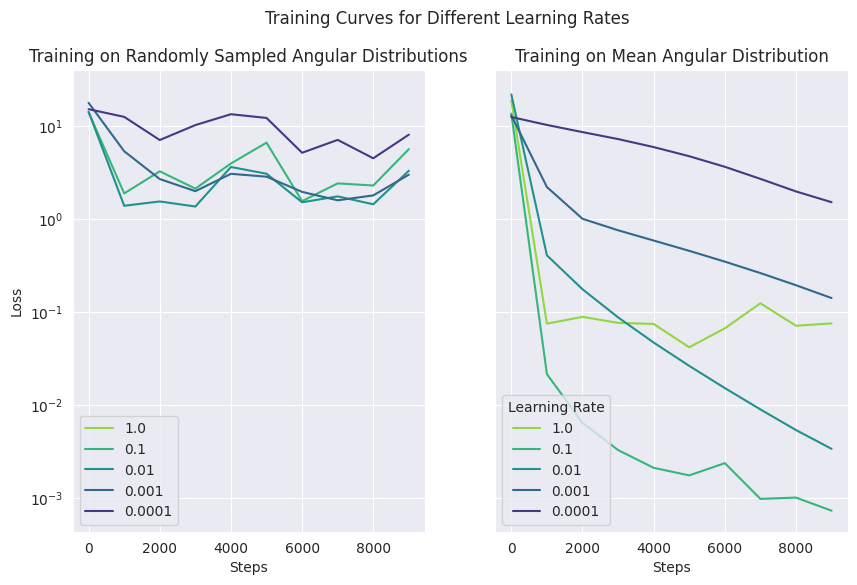

In [14]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)
for learning_rate in [1e0, 1e-1, 1e-2, 1e-3, 1e-4]:
    sns.lineplot(x=all_steps_by_hparams[(False, learning_rate)], y=all_losses_by_hparams[(False, learning_rate)],
                 ax=ax[0], hue=learning_rate, hue_norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e1), palette="viridis")
    sns.lineplot(x=all_steps_by_hparams[(True, learning_rate)], y=all_losses_by_hparams[(True, learning_rate)],
                 ax=ax[1], hue=learning_rate, hue_norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e1), palette="viridis")

fig.suptitle(f"Training Curves for Different Learning Rates")
ax[0].set_title("Training on Randomly Sampled Angular Distributions")
ax[1].set_title("Training on Mean Angular Distribution")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[0].set_yscale("log")
plt.legend(title="Learning Rate")
plt.show()
    

In [ ]:
use_mean_dist = True
learning_rate = 1e-2

all_steps = all_steps_by_hparams[(use_mean_dist, learning_rate)]
all_coeffs = all_coeffs_by_hparams[(use_mean_dist, learning_rate)]
# Make a slider plot of the angular distributions.
fig = go.Figure()
for step, coeffs in zip(all_steps, all_coeffs):
    step_dist = coeffs_to_dist(coeffs)
    step_dist.grid_values = step_dist.grid_values[0, :, :]
    step_trace = go.Surface(
        step_dist.plotly_surface(),
        colorscale=[[0, "rgba(4, 59, 192, 0.)"], [1, "rgba(4, 59, 192, 1.)"]],
        showscale=True,
        cmin=step_dist.grid_values.min().item(),
        cmax=step_dist.grid_values.max().item(),
        visible=False,
    )
    fig.add_trace(step_trace)

# Make 0th trace visible
fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Step: {all_steps[i]}"}],  # layout attribute
        label=f"{all_steps[i]}"
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Step: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()
